In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft
import scipy.signal
from scipy.io import wavfile

In [2]:
fs, data = wavfile.read("radio-chatter_F_minor.wav")

x_n = data

N = len(x_n)
T = N/fs
t = np.linspace(0, T, N)

X_k = np.fft.fft(x_n/N)
freq = np.fft.fftfreq(N, 1/fs)

C:\Users\magnu\AppData\Local\Temp/ipykernel_9756/3486314268.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read("radio-chatter_F_minor.wav")


Text(0, 0.5, 'x_n')

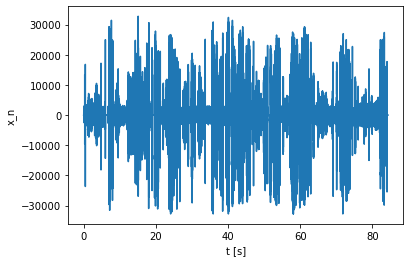

In [3]:
plt.plot(t, x_n)
plt.xlabel('t [s]')
plt.ylabel('x_n')

In [4]:
print(f"Det er {len(x_n)} elementer i lyd filen, med frekvens {fs}, som tilvarer et {T:0.3f}sekunder langt lydklipp")

Det er 3719701 elementer i lyd filen, med frekvens 44100, som tilvarer et 84.347sekunder langt lydklipp


In [5]:
start = int(6.9*fs)
end = int(11*fs)
x_n = data[start:end]

N = len(x_n)
T = N/fs
t = np.linspace(start/fs, end/fs, N)

X_k = np.fft.fft(x_n/N)
freq = np.fft.fftfreq(N, 1/fs)

Text(0, 0.5, 'x_n')

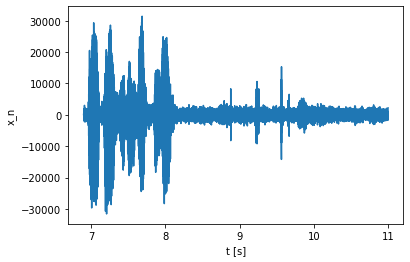

In [6]:
plt.plot(t, x_n)
plt.xlabel('t [s]')
plt.ylabel('x_n')

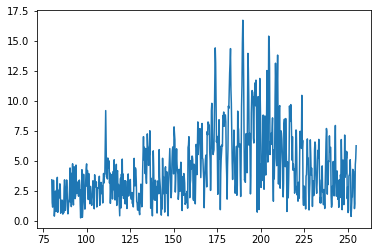

In [7]:
wavfile.write(f"Roger_human_voice.wav", fs, x_n[(80 < freq) & (freq < 255)].astype("float32"))
plt.plot(freq[(80 < freq) & (freq < 255)], abs(X_k[(80 < freq) & (freq < 255)]))

(0.0, 4800.0)

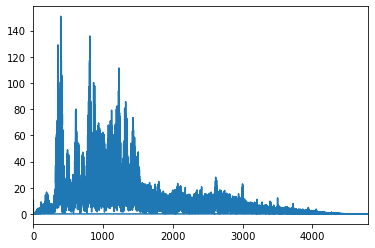

In [8]:
plt.plot(freq, abs(X_k))
plt.xlim(0, 4800)

In [9]:
def fft_filter_amp(threshold, x_k):
    x_k_abs = np.copy(np.abs(x_k))
    #x_k_abs = x_k_abs/max(x_k_abs)
    x_k_abs[x_k_abs<=threshold*max(x_k_abs)] = 0
    return x_k_abs

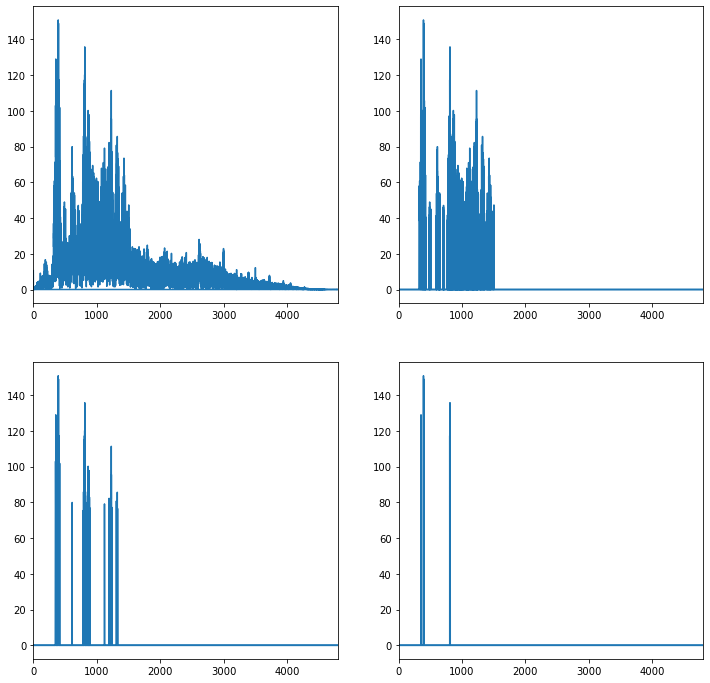

In [11]:
threshold = np.linspace(0, 1, 5)
threshold = threshold[0:len(threshold)-1]

plt.figure(figsize=(12, 12))
for  i in range(0, 4):
    plt.subplot(2, 2, i+1)
    threshold_filter = fft_filter_amp(threshold[i], X_k)

    plt.plot(freq, threshold_filter)
    plt.xlim(0, 4800)

Og om vi transformerer de tilbake:

In [ ]:
plt.figure(figsize=(12, 12))
for  i in range(0, 4):
    plt.subplot(2, 2, i+1)
    threshold_filter = fft_filter_amp(threshold[i], X_k)
    x_n_filter = np.real(np.fft.ifft(threshold_filter))
    plt.plot(t, x_n_filter)

In [19]:
def fft_filter(threshold, x_k):
    x_k_copy = np.copy(x_k)
    x_k_abs = abs(x_k_copy)
    x_k_copy[x_k_abs<=threshold*max(x_k_abs)] = 0
    return x_k_copy

In [ ]:
plt.figure(figsize=(12, 12))
for  i in range(0, 4):
    plt.subplot(2, 2, i+1)
    threshold_filter = fft_filter(threshold[i], X_k)
    x_n_filter = np.real(np.fft.ifft(threshold_filter))
    plt.plot(t, x_n_filter)
    wavfile.write(f"Roger_threshold{threshold[i]}.wav", fs, x_n_filter.astype("float32"))

Første metode fungerer ikke, videre prøver vi å isolere en del av lydopptaket hvor det kun er bakgrunnstøy og ikke noe stemme. Ser at dette er tilfelle mellom 8.2 sekunder og 8.8 sekunder.

In [ ]:
start_bg = int(8.2*fs)
end_bg = int(8.8*fs)
x_n_bg = data[start_bg:end_bg]

N = len(x_n_bg)
T = N/fs
t_bg = np.linspace(start_bg/fs, end_bg/fs, N)

X_k_bg = np.fft.fft(x_n_bg/N)
freq_bg = np.fft.fftfreq(N, 1/fs)

In [ ]:
plt.plot(t_bg, x_n_bg)
plt.xlabel('t [s]')
plt.ylabel('x_n_bg')

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(freq_bg, abs(X_k_bg))
plt.xlim(0, 4800)
plt.subplot(2, 1, 2)
plt.plot(freq, abs(X_k))
plt.xlim(0, 4800)

In [37]:
def fft_filter_sample(sample, x_k, sample_freq, freq):
    Ns = len(sample)
    Nk = len(x_k)
    factor = Nk/Ns
    tmp = np.zeros(Nk)
    tol = abs(sample_freq[0] - sample_freq[1])/2
    """for i in range(Ns):
        try:
            if abs(tmp[int(i*factor)] - x_k[int(i*factor)]) < tol:
                tmp[int(i*factor)] = x_k[int(i*factor)] - sample[i]
        except:
            pass
    """
    for i, f in enumerate(freq):
        for j, fs in enumerate(sample_freq):
            if abs(f - fs) < tol:
                tmp[int(i*factor)] = x_k[int(i*factor)] - sample[i]
    return tmp
        

In [ ]:
sample_filter = fft_filter_sample(X_k_bg, X_k)
x_n_filter = np.real(np.fft.ifft(sample_filter))
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
ax[0].plot(t, x_n_filter)
ax[1].plot(freq, abs(sample_filter))
ax[1].set_xlim(0, 4800)
ax[2].plot(freq_bg, abs(X_k_bg))
ax[2].set_xlim(0, 4800)
ax[3].plot(freq, abs(X_k))
ax[3].set_xlim(0, 4800)
wavfile.write(f"Roger_samplefilter.wav", fs, x_n_filter.astype("float32"))

Ny metode

In [ ]:
def fft_filter_perc(perc, x_k, freq, domain):
    tmp = abs(x_k[(domain[0] < freq) & (freq <domain[1])])/max(abs(x_k))
    
    amp = 0
    while np.count_nonzero(tmp < amp)/len(tmp) <= perc:
        print(np.count_nonzero(tmp < amp)/len(tmp), len(tmp))
        amp += 1/10
    print(amp)
    return np.where(x_k < amp, 0, x_k)

In [ ]:
plt.plot(freq[(0 < freq) & (freq < 4800)], abs(X_k[(0 <freq) & (freq < 4800)]))

In [ ]:
perc = [0.25, 0.5, 0.75, 0.9]
plt.figure(figsize=(12, 12))
for  i in range(3, 4):
    plt.subplot(2, 2, i+1)
    perc_filter = fft_filter_perc(perc[i], X_k, freq, [0, 4800])
    plt.plot(freq, perc_filter)
    plt.xlim(0, 4800)

In [ ]:
plt.figure(figsize=(12, 12))
for  i in range(0, 4):
    plt.subplot(2, 2, i+1)
    perc_filter = fft_filter_perc(perc[i], X_k, freq, [0, 4800])
    x_n_filter = np.real(np.fft.ifft(perc_filter))
    plt.plot(t, x_n_filter)
    wavfile.write(f"Roger_precentfilter{perc[i]}.wav", fs, x_n_filter.astype("float32"))

Ta sample, gå igjennom den. Der amplituden er over en viss grense, gå til det originale lydklippet og reduser amplituden til den frekvensen, prøv å redusere med 75%, 50%... osv. 

In [ ]:
def fft_filter_sample_threshold(sample, x_k, sample_freq, freq, th, reduction):
    tol = len(x_k)/len(sample)
    tmp = np.copy(freq)
    fmax = max(sample_freq)
    for f in sample_freq[sample_freq>=th*fmax]:
        tmp = np.where(abs(tmp-f) <= tol, reduction*tmp, tmp)
    return tmp

In [ ]:
plt.figure(figsize=(12, 12))
for  i in range(0, 4):
    plt.subplot(2, 2, i+1)
    threshold_filter = fft_filter_sample_threshold(X_k_bg, X_k, freq_bg, freq, threshold[i], 0.5)
    x_n_filter = np.real(np.fft.ifft(threshold_filter))
    plt.plot(t, x_n_filter)
    wavfile.write(f"Roger_threshold{threshold[i]}.wav", fs, x_n_filter.astype("float32"))

In [14]:
fs, data = wavfile.read("aircraft.wav")

x_n = data[:,0]

N = len(x_n)
T = N/fs
t = np.linspace(0, T, N)

X_k = np.fft.fft(x_n/N)
freq = np.fft.fftfreq(N, 1/fs)

Text(0, 0.5, 'x_n')

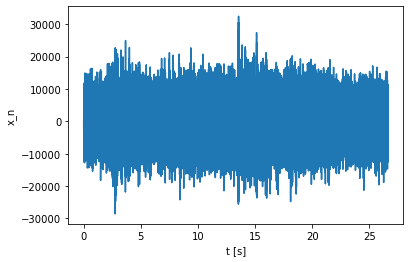

In [15]:
plt.plot(t, x_n)
plt.xlabel('t [s]')
plt.ylabel('x_n')

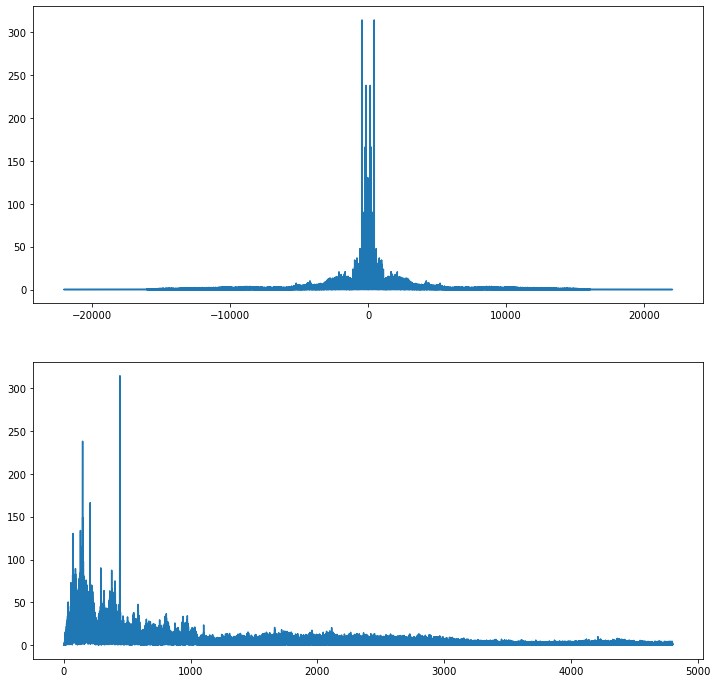

In [16]:
plt.figure(figsize=(12,12))
plt.subplot(2, 1, 1)
plt.plot(freq, abs(X_k))
plt.subplot(2, 1, 2)
plt.plot(freq[(0 < freq) & (freq < 4800)], abs(X_k[(0 <freq) & (freq < 4800)]))

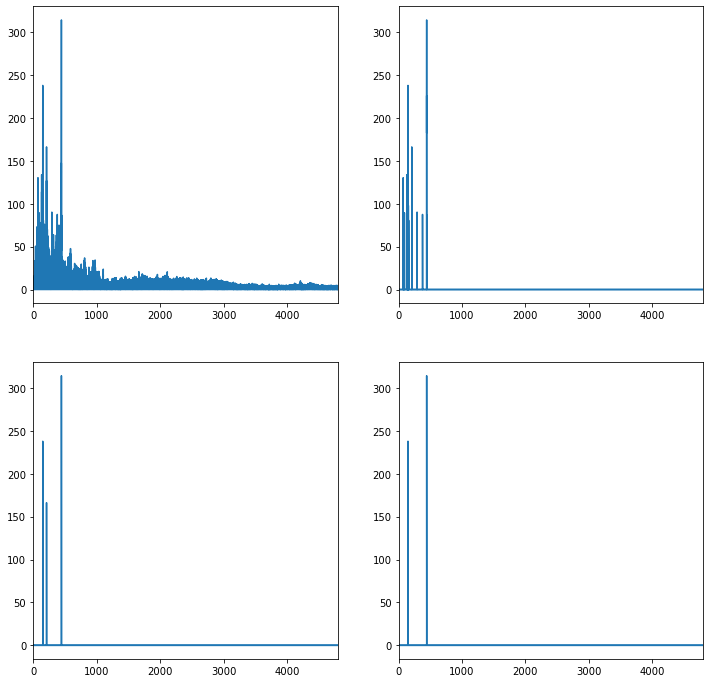

In [21]:
plt.figure(figsize=(12, 12))
for  i in range(0, 4):
    plt.subplot(2, 2, i+1)
    threshold_filter = fft_filter(threshold[i], X_k)

    plt.plot(freq, abs(threshold_filter))
    plt.xlim(0, 4800)

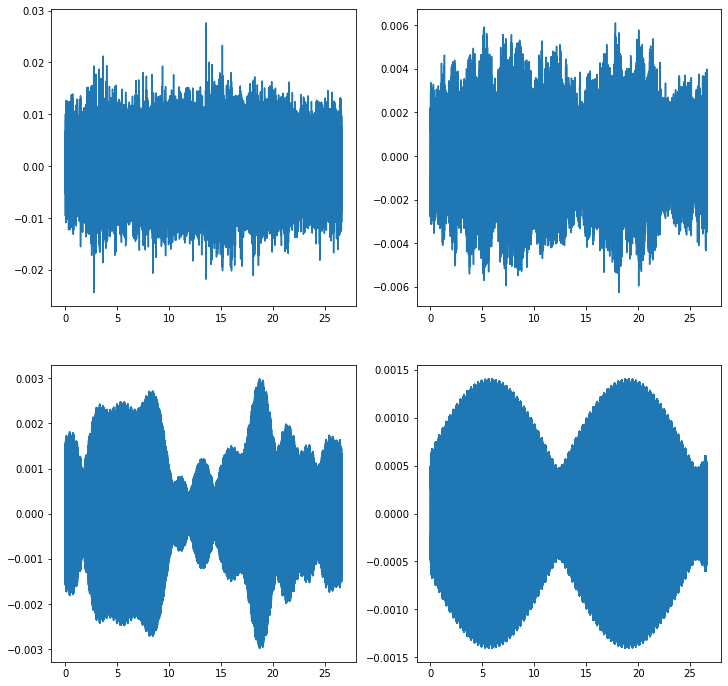

In [22]:
plt.figure(figsize=(12, 12))
for  i in range(0, 4):
    plt.subplot(2, 2, i+1)
    threshold_filter = fft_filter(threshold[i], X_k)
    x_n_filter = np.real(np.fft.ifft(threshold_filter))
    plt.plot(t, x_n_filter)
    wavfile.write(f"Airplane{threshold[i]}.wav", fs, x_n_filter.astype("float32"))

In [28]:
start_bg = int(8.2*fs)
end_bg = int(8.8*fs)
x_n_bg = data[start_bg:end_bg, 0]

N = len(x_n_bg)
T = N/fs
t_bg = np.linspace(start_bg/fs, end_bg/fs, N)

X_k_bg = np.fft.fft(x_n_bg/N)
freq_bg = np.fft.fftfreq(N, 1/fs)

In [43]:
def sample_filter(sample, x_k, sample_freq, freq):
    x_k_copy = np.copy(x_k)
    freq_copy = np.copy(freq)
    tol = abs(sample_freq[0] - sample_freq[1])/2
    for f in sample_freq:
        tmp = abs(freq_copy - f)
        x_k_copy = np.where(tmp < tol, 0, x_k_copy)
    return x_k_copy

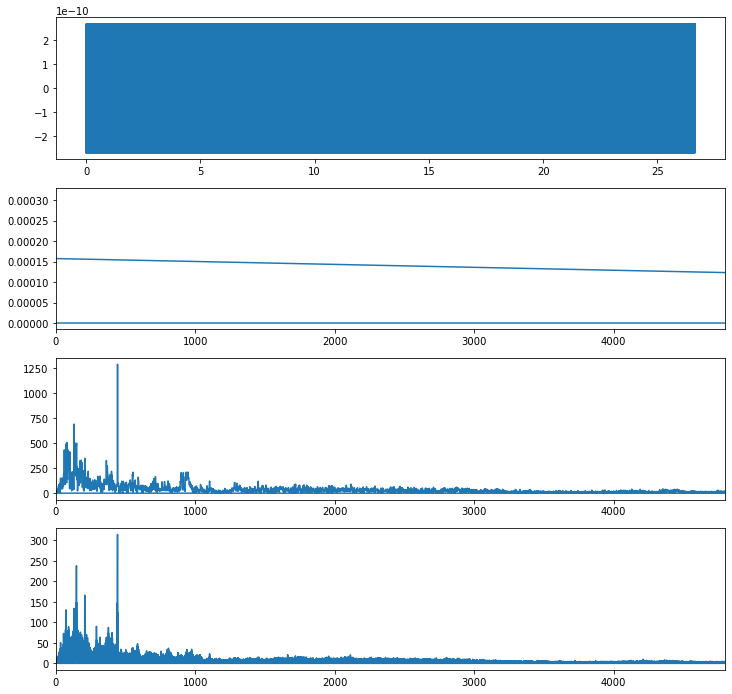

In [44]:
sample_filter = sample_filter(X_k_bg, X_k, freq_bg, freq)
x_n_filter = np.real(np.fft.ifft(sample_filter))
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
ax[0].plot(t, x_n_filter)
ax[1].plot(freq, abs(sample_filter))
ax[1].set_xlim(0, 4800)
ax[2].plot(freq_bg, abs(X_k_bg))
ax[2].set_xlim(0, 4800)
ax[3].plot(freq, abs(X_k))
ax[3].set_xlim(0, 4800)
wavfile.write(f"airplane_sample_filter.wav", fs, x_n_filter.astype("float32"))